In [1]:
import cv2
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np 
import re
import string
import json
from time import time
import pickle


In [2]:
import keras
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50,preprocess_input,decode_predictions
from keras.preprocessing import image
from keras.models import Model,load_model
from keras_preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input,Dense,Dropout,Embedding,LSTM
from keras.layers.merge import add

In [3]:
import nltk
from nltk.corpus import stopwords
import collections

In [4]:
# DATA COLLECTION

In [5]:
def read_file(path):
    with open(path) as f:
        captions=f.read()
    return captions

In [6]:
captions=read_file("./captions.txt")

In [7]:
print(len(captions.split("\n")))

40457


In [8]:
captions=captions.split("\n")

In [9]:
print(captions[0])
print(captions[1])
print(captions[-1])
print(captions[-2])

image,caption
1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .

997722733_0cb5439472.jpg,A rock climber practices on a rock climbing wall .


In [10]:
captions=captions[1:len(captions)-1]

In [11]:
print(captions[0])    # discarding last and first
print(captions[1])
print(captions[-1])
print(captions[-2])

1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg,A girl going into a wooden building .
997722733_0cb5439472.jpg,A rock climber practices on a rock climbing wall .
997722733_0cb5439472.jpg,A rock climber in a red shirt .


In [12]:
print(len(captions))

40455


In [13]:
desc=dict()

In [14]:
for ele in range(50):
    print(captions[ele])

1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg,A girl going into a wooden building .
1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .
1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting
1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with each other on the road .
1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots are staring at each other in the street .
1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each other on the road .
1001773457_577c3a7d70.jpg,Two dogs on pavement moving toward each other .
1002674143_1b742ab4b8.jpg,A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .
1002674143_1b742ab4b8.jpg,A little 

In [15]:
for ele in captions:
    items=ele.split(",")
    first,second=items[0],items[1]
    img_name=first.split(".")[0]
    if desc.get(img_name) is None:
        desc[img_name]=[]
    desc[img_name].append(second)

In [16]:
print(len(desc["1001773457_577c3a7d70"]))

5


In [17]:
print(desc["1001773457_577c3a7d70"])

['A black dog and a spotted dog are fighting', 'A black dog and a tri-colored dog playing with each other on the road .', 'A black dog and a white dog with brown spots are staring at each other in the street .', 'Two dogs of different breeds looking at each other on the road .', 'Two dogs on pavement moving toward each other .']


In [18]:
# TEXT CLEANING

In [19]:
img_path="./Images/"

In [20]:
random_img=cv2.imread(img_path+"1001773457_577c3a7d70.jpg")

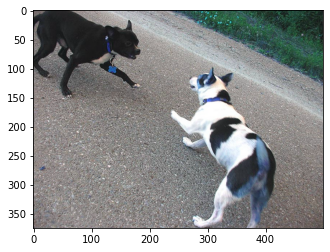

In [21]:
plt.imshow(random_img)
plt.show()

In [22]:
random_img=cv2.cvtColor(random_img,cv2.COLOR_BGR2RGB)   

A black dog and a spotted dog are fighting
A black dog and a tri-colored dog playing with each other on the road .
A black dog and a white dog with brown spots are staring at each other in the street .
Two dogs of different breeds looking at each other on the road .
Two dogs on pavement moving toward each other .


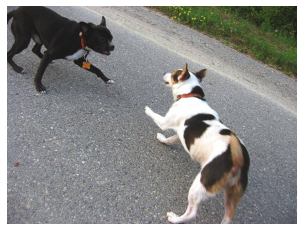

In [23]:
for ele in desc["1001773457_577c3a7d70"]:
    print(ele)

plt.imshow(random_img)
plt.axis("off")
plt.show()

In [24]:
def clean_text(sen):
    sen=sen.lower()
    sen=re.sub("[^a-z]+"," ",sen)
    # sen=sen.split()
    # print(sen)
    # sen=[s for s in sen if s!="#"]
    # sen=" ".join(sen)
    return sen

In [25]:
rand_sen="i like even numbers like 2,4,6"
print(clean_text(rand_sen))

i like even numbers like 


In [26]:
for key,cap_list in desc.items():
    for i in range(len(cap_list)):
        cap_list[i]=clean_text(cap_list[i])


In [27]:
f=open("desc.txt","w")
f.write(str(desc))
f.close()

In [28]:
# CREATING VOCAB

In [29]:
vocab=set()
for key in desc.keys():
    [vocab.update(sen.split()) for sen in desc[key]]

In [30]:
print(len(vocab))

8273


In [31]:
# print(vocab)

In [32]:
total_words=[]
for key in desc.keys():
    [total_words.append(i) for sen in desc[key] for i in sen.split()]

In [33]:
print(len(total_words))
# print(total_words)

419830


In [34]:
counter=collections.Counter(total_words)
freq_cnt=dict(counter)

In [35]:
print(freq_cnt)

1, 'trolley': 1, 'masters': 1, 'llama': 3, 'youths': 2, 'reacts': 2, 'emotionally': 1, 'spectate': 1, 'kangaroo': 6, 'somersaulting': 1, 'performed': 1, 'tbe': 1, 'daring': 2, 'burnt': 1, 'battons': 1, 'twome': 1, 'sync': 1, 'practising': 1, 'juming': 1, 'rears': 2, 'damp': 1, 'fiveteen': 1, 'exercised': 1, 'athletics': 1, 'littered': 4, 'joyful': 1, 'guessing': 1, 'treks': 3, 'meat': 3, 'desks': 3, 'buses': 4, 'headwraps': 2, 'tugboat': 3, 'aggresively': 1, 'hook': 2, 'defender': 1, 'slouching': 2, 'lunchbox': 2, 'nordic': 1, 'smiled': 1, 'whizzes': 1, 'piano': 9, 'viewing': 2, 'fastest': 1, 'emits': 1, 'flare': 1, 'indescript': 2, 'escalators': 1, 'expressionless': 1, 'swiftly': 1, 'buddhists': 1, 'pots': 1, 'advantage': 1, 'motorboat': 3, 'motors': 1, 'secluded': 1, 'investigates': 2, 'coloful': 1, 'holiday': 1, 'bathe': 3, 'windsailing': 1, 'boned': 1, 'physiques': 1, 'rd': 2, 'temporary': 1, 'steap': 1, 'geyser': 5, 'lkievely': 1, 'tinsel': 1, 'faint': 1, 'content': 1, 'torn': 4, 

In [36]:
print(len(freq_cnt.keys()))

8273


In [37]:
print(type(freq_cnt["wiffle"]))
# print(freq_cnt)

<class 'int'>


In [38]:
sort_freq_cnt=sorted(freq_cnt.items(),reverse=True,key=lambda x: x[1])
thres=10
sort_freq_cnt=[x for x in sort_freq_cnt if x[1]>thres]

In [39]:
total_words=[x[0] for x in sort_freq_cnt]   #list having unique words with freq gt than threshold freq

In [40]:
print(len(total_words))

1805


In [41]:
print(sort_freq_cnt)

, ('parade', 64), ('bicyclist', 64), ('chairs', 64), ('throws', 64), ('kicks', 64), ('painted', 63), ('pictures', 63), ('full', 63), ('hiking', 63), ('beard', 63), ('stage', 63), ('rugby', 63), ('backyard', 62), ('smaller', 62), ('wheel', 62), ('blanket', 62), ('silver', 62), ('outfits', 62), ('event', 62), ('box', 62), ('blowing', 62), ('leather', 62), ('cars', 61), ('sunny', 61), ('low', 61), ('steep', 61), ('swimsuit', 61), ('scooter', 61), ('cat', 61), ('surface', 60), ('statue', 60), ('make', 60), ('drinks', 60), ('glass', 59), ('sticks', 59), ('stuffed', 59), ('bald', 59), ('suits', 59), ('held', 59), ('volleyball', 59), ('smoking', 59), ('cow', 59), ('paint', 58), ('sleeping', 58), ('pushing', 58), ('using', 58), ('wrestling', 58), ('throw', 58), ('pointing', 58), ('staring', 57), ('net', 57), ('leans', 57), ('crossing', 57), ('hugging', 57), ('corner', 57), ('flower', 57), ('fluffy', 57), ('tube', 56), ('door', 56), ('attempting', 56), ('wrestle', 56), ('few', 56), ('bucket', 5

<h1> PREPARE TRAIN-TEST DATA </h1>

In [43]:
train_file=read_file("./flickr_text/Flickr_8k.trainImages.txt")
test_file=read_file("./flickr_text/Flickr_8k.testImages.txt")

In [44]:
train=train_file.split("\n")
train=train[:-1]
print(train[-1])

2671602981_4edde92658.jpg


In [45]:
train=[ele.split(".")[0] for ele in train]
print(train[:5])

['2513260012_03d33305cf', '2903617548_d3e38d7f88', '3338291921_fe7ae0c8f8', '488416045_1c6d903fe0', '2644326817_8f45080b87']


In [46]:
test=test_file.split("\n")
print(test[-1])
test=test[:-1]
print(test[-1])


3490736665_38710f4b91.jpg


In [47]:
test=[ele.split(".")[0] for ele in test]
print(test[:5])

['3385593926_d3e9c21170', '2677656448_6b7e7702af', '311146855_0b65fdb169', '1258913059_07c613f7ff', '241347760_d44c8d3a01']


In [48]:
train_desc=dict()    #contains img_id along with "ss+captions+ee" for training

In [49]:
for img_id in train:
    train_desc[img_id]=[]
    for cap in desc[img_id]:
        cap_new="ss "+cap+" ee"
        train_desc[img_id].append(cap_new)

In [50]:
print(train_desc["1001773457_577c3a7d70"])

['ss a black dog and a spotted dog are fighting ee', 'ss a black dog and a tri colored dog playing with each other on the road  ee', 'ss a black dog and a white dog with brown spots are staring at each other in the street  ee', 'ss two dogs of different breeds looking at each other on the road  ee', 'ss two dogs on pavement moving toward each other  ee']


<H1> IMAGE PROCESSING</H1>

In [52]:
model=ResNet50(weights="imagenet",input_shape=(224,224,3))
print(model.summary())

]           
__________________________________________________________________________________________________
conv4_block1_1_bn (BatchNormali (None, 14, 14, 256)  1024        conv4_block1_1_conv[0][0]        
__________________________________________________________________________________________________
conv4_block1_1_relu (Activation (None, 14, 14, 256)  0           conv4_block1_1_bn[0][0]          
__________________________________________________________________________________________________
conv4_block1_2_conv (Conv2D)    (None, 14, 14, 256)  590080      conv4_block1_1_relu[0][0]        
__________________________________________________________________________________________________
conv4_block1_2_bn (BatchNormali (None, 14, 14, 256)  1024        conv4_block1_2_conv[0][0]        
__________________________________________________________________________________________________
conv4_block1_2_relu (Activation (None, 14, 14, 256)  0           conv4_block1_2_bn[0][0]        

In [53]:
model_new=Model(model.input,model.layers[-2].output)

In [54]:
def preprocess_img(img):
    img=image.load_img(img,target_size=(224,224))
    img=image.img_to_array(img)
    img=np.expand_dims(img,axis=0)
    img=preprocess_input(img)
    return img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


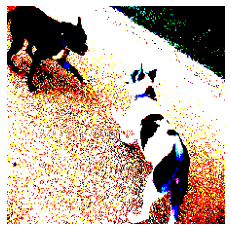

In [55]:
img=preprocess_img(img_path+"1001773457_577c3a7d70.jpg")
# img=preprocess_img(random_img)
plt.imshow(img[0])    # converting 4d-tensor to 3d-tensor
plt.axis("off")
# plt.imshow(random_img)
plt.show()

In [56]:
def encode_img(img):
    img=preprocess_img(img)
    feature_vec=model_new.predict(img)
    # print(feature_vec.shape)
    feature_vec=feature_vec.reshape((-1,))
    # print(feature_vec.shape)
    return feature_vec

In [57]:
encode_img(img_path+"1001773457_577c3a7d70.jpg")

array([0.78422934, 0.8189699 , 0.06491463, ..., 0.08858163, 0.68537325,
       0.1874958 ], dtype=float32)

In [58]:
encoding_train=dict()   # storing feature vector for each training image
# i=0
# start=time()
# for img_id in train:
#     path_img=img_path+img_id+".jpg"
#     encoding_train[img_id]=encode_img(path_img)
#     i+=1
#     if i%100==0:print("training in progress",i)
# end=time()
# print("time taken=",end-start)

In [59]:
# with open("encoded_train_features.pkl","wb") as f:
#     pickle.dump(encoding_train,f)

In [60]:
encoding_test=dict()   
# i=0
# start=time()
# for img_id in test:
#     path_img=img_path+img_id+".jpg"
#     encoding_test[img_id]=encode_img(path_img)
#     i+=1
#     if i%100==0:print("training in progress",i)
# end=time()
# print("time taken=",end-start)

In [61]:
# with open("encoded_test_features.pkl","wb") as f:
#     pickle.dump(encoding_test,f)

In [63]:
with open("encoded_train_features.pkl","rb") as f:    # pickle load for encoding_test andencoding_train
    encoding_train=pickle.load(f)
print(encoding_train)

8744627 ,
       0.31946343], dtype=float32), '3561734666_344f260cce': array([0.4744366 , 0.24742723, 0.04152649, ..., 1.9696573 , 0.17473811,
       0.7345749 ], dtype=float32), '2144050118_3e7d2e05b1': array([0.9103361 , 0.8704867 , 0.        , ..., 0.        , 0.1211354 ,
       0.37589392], dtype=float32), '241347271_a39a5a0070': array([0.3287439 , 3.2466266 , 0.00944724, ..., 0.54194164, 0.23252703,
       0.08277743], dtype=float32), '3576250302_14779632bd': array([0.78148246, 0.7609274 , 0.145479  , ..., 0.15213777, 0.57583904,
       0.19205932], dtype=float32), '3627676364_1dc9294ec5': array([0.04299927, 1.7774397 , 0.12991278, ..., 0.16087031, 0.97657996,
       0.16098367], dtype=float32), '3461114418_c27b4043a2': array([0.6070356 , 0.80401754, 0.04261167, ..., 0.20203647, 0.20537066,
       0.09941673], dtype=float32), '3646970605_d25c25340b': array([1.105624  , 2.3022947 , 0.02274082, ..., 0.7131814 , 0.08269546,
       2.1559312 ], dtype=float32), '2887614578_ed7ba21775':

In [64]:
with open("encoded_test_features.pkl","rb") as f:    # pickle load for encoding_test andencoding_train
    encoding_test=pickle.load(f)
print(encoding_test)

,
       0.31057578], dtype=float32), '3364151356_eecd07a23e': array([0.34363344, 0.2826029 , 0.2080773 , ..., 0.44344008, 0.7090687 ,
       0.8804889 ], dtype=float32), '2251747182_6b67a3ab8b': array([0.16181992, 0.3079636 , 0.01543462, ..., 1.0163972 , 2.2724953 ,
       0.41530085], dtype=float32), '3139160252_75109e9e05': array([0.73451763, 0.23299238, 0.060411  , ..., 0.72431153, 0.7147624 ,
       0.        ], dtype=float32), '219070971_ae43410b9e': array([0.30544642, 1.9166777 , 0.27689084, ..., 0.27715757, 1.4679036 ,
       0.        ], dtype=float32), '1674612291_7154c5ab61': array([0.3004234 , 0.74364775, 0.1976502 , ..., 0.633893  , 0.1461903 ,
       0.1596116 ], dtype=float32), '136886677_6026c622eb': array([0.0941369 , 0.03330354, 1.965263  , ..., 0.26439604, 1.5073929 ,
       0.6715644 ], dtype=float32), '3398746625_5199beea71': array([0.157215  , 1.052826  , 0.01652881, ..., 1.2328638 , 0.46608672,
       0.32752016], dtype=float32), '3220650628_4ed964e5b4': array([0

<H1> PREPROCESSING CAPTIONS</H1>

In [104]:
word_to_idx=dict()
idx_to_word=dict()
for i,word in enumerate(total_words):
    word_to_idx[word]=i+1
    idx_to_word[i+1]=word
last=len(word_to_idx)
print(last)
word_to_idx["ss"]=last+1
idx_to_word[last+1]="ss"
word_to_idx["ee"]=last+2
idx_to_word[last+2]="ee"
vocab_size=len(idx_to_word)+1   # foro zero
last=len(word_to_idx)
print(last)
print(vocab_size)

1805
1807
1808


In [105]:
print(idx_to_word[5])
print(word_to_idx["girl"])

is
17


In [119]:
max_len=0 
for key in train_desc.keys():
    for cap in train_desc[key]:
        max_len=max(max_len,len(cap.split()))

In [120]:
print(max_len)

35


<H1> MAKING CUSTOM DATA GENERATOR</H1>

In [69]:
def data_gen(train_desc,encoding_train,word_to_idx,max_len,batch_size):
    x1,x2,y=[],[],[]
    n=0
    while True:
        for key,desc_list in train_desc.itmes():
            n+=1
            photo=encoding_train[key+'.jpg']
            for desc in desc_list:
                seq=[word_to_idx[word] for word in desc.split() if word in word_to_idx]
                for i in range(1,len(seq)):
                    xi=seq[0:i]
                    yi=seq[i]
                    xi=pad_sequences([xi],maxlen=max_len,value=0,padding="post")[0]
                    yi=to_categorical([yi],num_classes=vocab_size)
                    x1.append(photo)
                    x2.append(xi)
                    y.append(yi)

                if n==batch_size:
                    yield ([np.array(x1),np.array(x2)],np.array(y))
                    n=0
                    x1,x2,y=[],[],[]

In [87]:
f=open("./glove.6B.50d.txt",encoding="utf-8")

In [88]:
embedding_idx=dict()
for line in f:
    values=line.split()
    word=values[0]
    word_embeddings=np.array(values[1:],dtype="float")
    embedding_idx[word]=word_embeddings

In [114]:
print(embedding_idx["girl"])
# print(embedding_idx["girl"])

[-0.34471   0.69563  -0.78086  -0.58482   1.2263    1.2544   -0.76466
  0.40575   0.18862   0.098834  0.32557  -0.31816   0.23869   0.33554
  1.0592   -0.25266  -1.0308    0.70027   0.030457  0.53866  -0.30279
  1.7515    0.3128    1.2103    0.41335  -1.9421   -0.93756   0.32453
  0.52249  -0.86708   2.1258   -0.20377  -0.19061   0.37736   0.66205
  0.50211  -0.12544  -0.83069   0.21155  -1.3091   -0.44973  -0.11648
  0.033598 -0.68382   0.99419  -0.88262   0.56601  -1.327     0.37319
  0.022389]


In [91]:
f.close()

In [94]:
def emb_matrix():
    emb_dim=50
    matrix=np.zeros((vocab_size,emb_dim))
    for word,idx in word_to_idx.items():
        emb_vec=embedding_idx.get(word)
        if emb_vec is not None:
            matrix[idx]=emb_vec
    return matrix


In [97]:
embedding_matrix=emb_matrix()
print(embedding_matrix.shape)

(1808, 50)


In [115]:
print(last)
print(embedding_matrix[last])   # ss and ee are present in the embeddings

1807
[ 1.0347    2.1967    1.1182   -0.44528  -1.5944   -1.422    -0.41429
 -1.8638   -0.86332   1.1378   -0.25959   1.8018   -0.39329   1.2401
  0.089999  1.7526   -0.73218  -1.3039    0.82317   1.672    -1.2966
 -0.36759   0.94428   0.56053  -1.1786   -1.6371   -0.16837   0.59888
 -0.682    -0.39279  -0.49019   0.009579 -1.2081    1.5057    1.0076
 -0.84401   0.37071  -0.26217   1.2949    0.51514   0.47997   2.3818
  0.46945   0.12777   0.59245   0.22244   0.43316  -0.6377    0.64054
  0.077589]


<h1>MODEL IMPLEMENTATION</h1>

In [117]:
input_img_features=Input(shape=(2048,))
inp_img1=Dropout(0.4)(input_img_features)
inp_img2=Dense(256,activation="relu")(inp_img1)

In [121]:
input_captions=Input(shape=(max_len))
inp_cap1=Embedding(input_dim=vocab_size,output_dim=50,mask_zero=True)(input_captions)
inp_cap2=Dropout(0.4)(inp_cap1)
inp_cap3=LSTM(256)(inp_cap2)


In [122]:
decoder1=add([inp_img2,inp_cap3])
decoder2=Dense(256,activation="relu")(decoder1)
outputs=Dense(vocab_size,activation="softmax")(decoder2)

In [123]:
model=Model(inputs=[input_img_features,input_captions],outputs=outputs)
print(model.summary())

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 35)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 35, 50)       90400       input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_2[0][0]                    
_______________________________________________________________________________________

In [124]:
print(model.layers[2])

In [125]:
model.layers[2].set_weights=([embedding_matrix])
model.layers[2].trainable=False

In [127]:
model.compile(loss="categorical_crossentropy",optimizer="adam")

<h1>TRAINING MODEL</h1>

In [129]:
epochs=20
batch_size=3
steps=len(train_desc)//number_pics_per_batch
def train():
    pass

NameError: name 'number_pics_per_batch' is not defined